# Exercises 1 - MNIST Optical Character Recognition
### Course: Convolutional Neural Networks with Applications in Medical Image Analysis
Office hours: Mondays 13.15--15.00 (Tommy), Tuesdays 13.15--16.00 (Minh), Thursdays 08.15--12.00 (Attila)

Below is an example notebook for a simple Keras pipeline. The dataset is MNIST (http://yann.lecun.com/exdb/mnist/), where each image is of a handwritten digit of 0-9.

## Initialize

In [1]:
import matplotlib.pyplot as plt 
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [2]:
SEED = 1

# See if GPU is available to use
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    use_cuda = True
else:
    use_cuda = False
    
device = torch.device("cuda" if use_cuda else "cpu")    

## Dataset

In [3]:
batch_size = 50

# Train loader
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

In [4]:
# Test loader
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=1000)

## Model

In [5]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        # input is 28x28
        # padding=2 for same padding
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        # feature map size is 14*14 by pooling
        # padding=2 for same padding
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        # feature map size is 7*7 by pooling
        self.fc1 = nn.Linear(64*7*7, 1024)
        self.fc2 = nn.Linear(1024, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 64*7*7)   # reshape Variable
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
model = MnistModel()

model = model.to(device)

model

MnistModel(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [6]:
# check model parameter
for p in model.parameters():
    print(p.size())

torch.Size([32, 1, 5, 5])
torch.Size([32])
torch.Size([64, 32, 5, 5])
torch.Size([64])
torch.Size([1024, 3136])
torch.Size([1024])
torch.Size([10, 1024])
torch.Size([10])


In [7]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## Train

In [8]:
print(device)

cuda


In [9]:
model.train()
train_loss = []
train_accu = []
i = 0
for epoch in range(1):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()    # calc gradients
        train_loss.append(loss.item())
        optimizer.step()   # update gradients
        prediction = output.data.max(1)[1]   # first column has actual prob.
        accuracy = prediction.eq(target.data).sum()/batch_size*100
        train_accu.append(accuracy)        
        if i % 100 == 0:
            print('Epoch: {}\tTrain Step: {}\t\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(epoch, i, loss.item(), accuracy))
        i += 1

Epoch: 0	Train Step: 0		Loss: 2.298	Accuracy: 0.000


<ipython-input-5-344ef8cfba95>:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epoch: 0	Train Step: 100		Loss: 0.680	Accuracy: 0.000
Epoch: 0	Train Step: 200		Loss: 0.397	Accuracy: 0.000
Epoch: 0	Train Step: 300		Loss: 0.419	Accuracy: 0.000
Epoch: 0	Train Step: 400		Loss: 0.260	Accuracy: 0.000
Epoch: 0	Train Step: 500		Loss: 0.136	Accuracy: 0.000
Epoch: 0	Train Step: 600		Loss: 0.213	Accuracy: 0.000
Epoch: 0	Train Step: 700		Loss: 0.276	Accuracy: 0.000
Epoch: 0	Train Step: 800		Loss: 0.124	Accuracy: 0.000
Epoch: 0	Train Step: 900		Loss: 0.070	Accuracy: 0.000
Epoch: 0	Train Step: 1000		Loss: 0.119	Accuracy: 0.000
Epoch: 0	Train Step: 1100		Loss: 0.136	Accuracy: 0.000


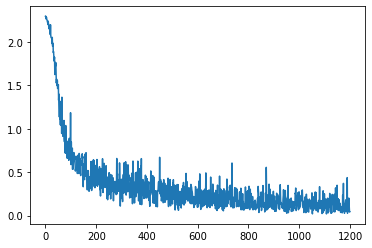

In [10]:
plt.plot(np.arange(len(train_loss)), train_loss)

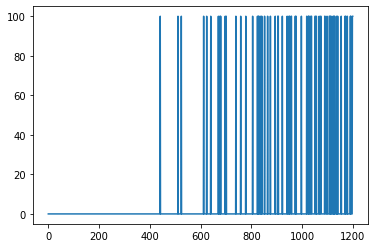

In [11]:
plt.plot(np.arange(len(train_accu)), train_accu)

## Evaluate

In [12]:
model.eval()
correct = 0
for data, target in test_loader:
    data, target = Variable(data, volatile=True), Variable(target)
    data, target = data.to(device), target.to(device)
    data, target = Variable(data), Variable(target)
    output = model(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()

print('\nTest set: Accuracy: {:.2f}%'.format(100. * correct / len(test_loader.dataset)))

<ipython-input-12-adb3a1c5afa8>:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
<ipython-input-5-344ef8cfba95>:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Accuracy: 96.84%
